# Assignment 12: Radial Basis Function Network

In this assignment, we show an alternative learning strategy that has been forgotten in the last few years but might get more popularity in the near future.
A radial basis function layer has some similarities with a fully-connected layer, but the outputs of the layer are not determined by a dot product between the weights and the input but rather by computing a distance.
Unfortunately, `PyTorch` does not provide us with an implementation of an RBF layer, so we need to implement our own.
Additionally, the activation function is replaced by a function that creates higher outputs for small absolute inputs, such as a Gaussian distribution:

$$a_r = ||\vec w_r - \vec x||^2 , h_r = e^{-\frac{a_r^2}{2 \sigma_r^2}}$$



Finally, we want to combine the convolutional network with an RBF layer and a final fully-connected layer to compute the 10 outputs.
For simplicity, let us define $K$ as the input dimension of our RBF layer, $R$ as the number of basis functions (the number of outputs) of our RBF layer, and $O=10$ as the number of outputs (logits) of our network.
The complete network topology is given below.
We are both interested in the deep feature representation that is the output of the first fully-connected layer and in the logits that are output from the second fully-connected layer.

1. 2D convolutional layer with $Q_1$ channels, kernel size $5\times5$, stride 1 and padding 2
2. 2D maximum pooling layer with kernel size $2\times2$ and stride 2
3. Activation function ReLU
4. 2D convolutional layer with $Q_2$ channels, kernel size $5\times5$, stride 1 and padding 2
5. 2D maximum pooling layer with kernel size $2\times2$ and stride 2
6. Activation function ReLU
7. Flatten layer to convert the convolution output into a vector
8. Fully-connected layer with the correct number of inputs and $K$ outputs
9. RBF layer with $K$ inputs and $R$ outputs (implemented in Task 2)
10. RBF activation function (implemented in Task 3)
11. Fully-connected layer with $R$ inputs and $O$ outputs

## Dataset

We will train and test our methods on the MNIST dataset.

### Task 1: Dataset

We will make use of the default implementations of the MNIST dataset.
As usual, we will need the training and validation set splits of MNIST, including data loaders.
Select appropriate batch sizes for training and validation sets.

In [1]:
import torch
import torchvision

# define transformation
transform = torchvision.transforms.ToTensor()
B = 512

# training set and data loader
train_set = torchvision.datasets.MNIST(root="./", train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size = B)

# validation set and data loader
validation_set = torchvision.datasets.MNIST(root="./", train=False, transform=transform, download=True)
validation_loader = torch.utils.data.DataLoader(validation_set, shuffle=False, batch_size = B)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Radial Basis Function

We will split our implementation into three different parts.
First, we implement the output $a_r$ as provided above.
Second, we implement the activation function $h_r$.
Finally, we build our network by inserting an RBF layer in between the fully-connected layers of our default network.

In order to implement the output $a_k$ of the RBF layer, we will use a weight matrix $\mathbf W\in \mathbb R^{R\times K} = \left[\vec w_1, \vec w_2,\ldots, \vec w_R \right]$ where each vector is of dimension $K$.
When handling batches $\mathbf X \in \mathbb R^{B\times K}$, we require to compute our activations as:

  $$\mathbf A \in \mathbb R^{B\times R} = (a_{n,r}) \qquad \text{with} \qquad a_{n,r} =  \bigl\|\vec w_r - \vec x^{[n]}\bigr\|^2 = \sum\limits_{k=1}^K \bigl\|w_{r,k} - \vec x_r^{[n]}\bigr\|^2$$

In order to speed up processing and enable the use of `tensor` operations, we need to bring $\mathbf W$ and $\mathbf X$ to the same size $\mathbb R^{B\times R\times K}$ by logically (**not physically!**) copying the data and the weights to $\mathcal W$ and $\mathcal X$.
Then, the resulting $ \mathcal A = || \mathcal W - \mathcal X||$ needs to be summed up over dimension $K$ to arrive at $\mathbf A$ as given above.


### Task 2: Radial Basis Function Layer

Implement the RBF layer in PyTorch that computes the activation $\mathbf A$ of a radial basis function. Derive your layer from `torch.nn.Module`.
In the `__init__` function, instantiate the weight matrix $\mathbf W$ as a `torch.nn.Parameter`, and initialize the weight values randomly from values in range $[-2,2]$.
In `forward`, compute and return the activation from the stored weight matrix and the given input batch as indicated above.


In [2]:
class RBFLayer(torch.nn.Module):
  def __init__(self, K, R):
    # call base class constructor
    super(RBFLayer, self).__init__()
    # initialize the matrix between -2 and 2
    self.W = torch.nn.Parameter(torch.empty((R, K)))
    torch.nn.init.uniform_(self.W, -2., 2.)

  def forward(self, x):
    # collect the required shape parameters, B, R, K
    B, R, K = x.shape[0], self.W.shape[0], self.W.shape[1]
    # Bring the weight matrix of shape R,K to size B,R,K by adding batch dimension (dim 0)
    W = self.W.unsqueeze(0).expand(B, R, K)
    # Bring the input matrix of shape B,K to size B,R,K by adding R dimension (dim 1)
    X = x.unsqueeze(1).expand(B, R, K)
    # compute the activation A - [B, R]
    A = torch.sum((W-X)**2, dim=-1)
    return A

### Task 3: Radial Basis Function Activation

The activation function also requires a `Parameter`, i.e., the standard deviations of the Gaussian.
Hence, we need to implement the activation function also as a `torch.nn.Module`.
Here, we are treating the denominator of the Gaussian as a separate variable: `sigma2 = 2*sigma*sigma`.

$$h_r = e^{-\frac{a_r^2}{2 \sigma_r^2}}$$

Implement the activation function with learnable `sigma2` parameters.
Initialize all `sigma` parameters with the value of 1.




In [3]:
class RBFActivation(torch.nn.Module):
  def __init__(self, R):
    # call base class constructor
    super(RBFActivation, self).__init__()
    # store a learnable parameter for the basis functions
    sigma = torch.ones((R,))
    self.sigma2 = torch.nn.Parameter(2 * sigma**2)
  def forward(self, a):
    # implement the RBF activation function
    output = torch.exp(-a / self.sigma2)
    return output

### Test 1: RBF Layer and Activation

We instantiate an RBF layer and an RBF activation function for $K=4$ and $R=12$ and generate a random batch of size $B=16$.
We call both the RBF layer and the activation on the batch, and make sure that the resulting output is of shape $B\times R$.
This test also assures that the layers above are functioning and do not raise exceptions.

In [4]:
# instantiate layer and activation
test_RBF_layer = RBFLayer(K=4, R=12)
test_RBF_activation = RBFActivation(R=12)

# create test data batch
test_data = torch.empty((16,4))

# forward test data through the layer and the activation
a = test_RBF_layer(test_data)
h = test_RBF_activation(a)

# check that the shape is correct
assert h.shape == (16,12)

### Task 4: Radial Basis Function Network

As the network, we rely on our convolutional network from Assignment 8.
However, this time we add an RBF layer and its activation between the first and the second fully-connected layer.
We will return both the deep features of dimension $K$ and the logits of dimension $O$ in `forward`, which we will use later for visualization purposes.
Note that the processing will happen on batch level.




In [5]:
class RBFNetwork(torch.nn.Module):
  def __init__(self, Q1, Q2, K, R, O):
    # call base class constrcutor
    super(RBFNetwork,self).__init__()
    # convolutional define layers
    self.conv1 = torch.nn.Conv2d(1, Q1, 5, 1, 2)
    self.conv2 = torch.nn.Conv2d(Q1, Q2, 5, 1, 2)
    # pooling and activation functions will be re-used for the different stages
    self.pool = torch.nn.MaxPool2d(2, 2)
    self.act = torch.nn.ReLU()
    # define fully-connected layers
    self.flatten = torch.nn.Flatten()
    self.fc1 = torch.nn.Linear(49*Q2, K, bias=True)
    # define RBF layer and its activation
    self.rbf_layer = RBFLayer(K, R)
    self.rbf_activation = RBFActivation(R)
    # define second fully-connected layer
    self.fc2 = torch.nn.Linear(R, O, bias=True)
  
  def forward(self,x):
    a = self.act(self.pool(self.conv1(x)))
    a = self.act(self.pool(self.conv2(a)))
    # get the deep feature layer as the output of the first fully-connected layer
    deep_feature = self.fc1(self.flatten(a))
    # apply the RBF layer and activation
    h_r = self.rbf_activation(self.rbf_layer(deep_feature))
    # apply the last fully-connected layer to obtain the logits
    logits = self.fc2(h_r)
    # return both the logits and the deep features
    return logits, deep_feature


### Task 5: Training and Validation Loop

The training and validation loops are as usual.
Instantiate the network with $Q_1=64$, $Q_2=32$, $K=2$, $R=100$ and $O=10$.
Instantiate loss function and optimizer.
Train the network on the training set.
Compute the validation set accuracy after each epoch of training.

Hints: 

* The validation set accuracy after the first epoch should be more than 80%. If it is much lower, increase the learning rate and/or change the optimizer.
* On the other hand, if the accuracy gets stuck around 10% and does not change over the epochs, reduce the learning rate.
* The training on the GPU might take several minutes. On the CPU, training times might be increased.

In [6]:
def training_loop(network:torch.nn.Module, Epoch=10, lr=1e-3):
  optimizer = torch.optim.Adam(network.parameters(), lr=lr)
  loss_func = torch.nn.CrossEntropyLoss()

  for epoch in range(Epoch):
    acc_train = 0.
    loss_train = 0.
    for x,t in train_loader:
      z, _ = network(x.to(device))
      
      optimizer.zero_grad()
      loss = loss_func(z, t.to(device))
      loss_train += loss.item() * len(x) / len(train_set)
      
      loss.backward()
      optimizer.step()
      
      acc_train += torch.sum(torch.argmax(z, dim=1) == t.to(device)).item()

    # compute validation set accuracy
    acc_valid = 0
    with torch.no_grad():
      for x,t in validation_loader:
        z, _ = network(x.to(device))
        acc_valid += torch.sum(torch.argmax(z, dim=1)==t.to(device)).item()

    print(F"Epoch {epoch+1} - train loss: {loss_train:.6f}, train accuracy: {acc_train/len(train_set):1.4f} test accuracy: {acc_valid/len(validation_set):1.4f}")

In [64]:
# instantiate RBFnetwork and train model
network = RBFNetwork(Q1=64, Q2=32, K=2, R=100, O=10).to(device)

training_loop(network, Epoch=20, lr=1e-3)

Epoch 1 - train loss: 1.618648, train accuracy: 0.5862 test accuracy: 0.8391
Epoch 2 - train loss: 0.772602, train accuracy: 0.8780 test accuracy: 0.9128
Epoch 3 - train loss: 0.474324, train accuracy: 0.9217 test accuracy: 0.9332
Epoch 4 - train loss: 0.340567, train accuracy: 0.9390 test accuracy: 0.9396
Epoch 5 - train loss: 0.266716, train accuracy: 0.9488 test accuracy: 0.9469
Epoch 6 - train loss: 0.226752, train accuracy: 0.9544 test accuracy: 0.9498
Epoch 7 - train loss: 0.196690, train accuracy: 0.9588 test accuracy: 0.9512
Epoch 8 - train loss: 0.170272, train accuracy: 0.9627 test accuracy: 0.9574
Epoch 9 - train loss: 0.152735, train accuracy: 0.9664 test accuracy: 0.9546
Epoch 10 - train loss: 0.136824, train accuracy: 0.9697 test accuracy: 0.9548
Epoch 11 - train loss: 0.124251, train accuracy: 0.9727 test accuracy: 0.9611
Epoch 12 - train loss: 0.112852, train accuracy: 0.9748 test accuracy: 0.9607
Epoch 13 - train loss: 0.103817, train accuracy: 0.9771 test accuracy: 0.

### (Optional) Task 5a: 

Consider the minimum number for $R$, and use this number to train the model.

In [8]:
# instantiate RBFnetwork and train model
network_minimal = RBFNetwork(Q1=64, Q2=32, K=2, R=10, O=10).to(device)
training_loop(network_minimal, Epoch=25, lr=1e-3)

Epoch 1 - train loss: 2.086714, train accuracy: 0.3598 test accuracy: 0.5190
Epoch 2 - train loss: 1.787551, train accuracy: 0.5319 test accuracy: 0.5527
Epoch 3 - train loss: 1.573082, train accuracy: 0.6236 test accuracy: 0.6402
Epoch 4 - train loss: 1.411513, train accuracy: 0.6689 test accuracy: 0.7066
Epoch 5 - train loss: 1.281911, train accuracy: 0.7121 test accuracy: 0.7093
Epoch 6 - train loss: 1.170735, train accuracy: 0.7311 test accuracy: 0.7375
Epoch 7 - train loss: 1.074685, train accuracy: 0.7464 test accuracy: 0.7653
Epoch 8 - train loss: 0.990502, train accuracy: 0.7652 test accuracy: 0.7655
Epoch 9 - train loss: 0.917904, train accuracy: 0.7882 test accuracy: 0.8044
Epoch 10 - train loss: 0.854694, train accuracy: 0.8110 test accuracy: 0.8084
Epoch 11 - train loss: 0.798523, train accuracy: 0.8319 test accuracy: 0.8269
Epoch 12 - train loss: 0.749807, train accuracy: 0.8423 test accuracy: 0.8313
Epoch 13 - train loss: 0.704433, train accuracy: 0.8521 test accuracy: 0.

## Visualization
We have selected the dimensionality of the deep features to be $K=2$ in order to be able to visualize them.
The goal is to extract the deep feature representations of all validation samples.
For each sample, we regard the 2D representation as a point in a 2D space, which we can mark with a color that is dependent on the label of that sample.
After plotting a dot for each of the validation samples, we can observe if we find some structure in the feature space.

Finally, also the learned basis functions $\vec w_r$ can be plotted, including their according to size $\sigma_r$.
This allows us to see whether the RBF network has adapted itself to the data.

### Task 6: Deep Feature Extraction

Iterate through the validation set samples and extract the 2D deep feature representations for the images.
Store the results in 10 different lists, one for each target class.

In [11]:
def get_features(network):
  # extract all deep features for all validation set samples
  features = [[] for _ in range(10)]

  with torch.no_grad():
    for x,t in validation_loader:
      # extract deep features
      _, deep_feature = network(x.to(device)) # [B, K]
      # separate the 10 different targets into separate lists
      for idx, digit in enumerate(t):
        features[digit].append(deep_feature[idx])

  # convert features to 2D for later processing/plotting
  features = [torch.stack(f, dim=0) for f in features]
  return features

In [ ]:
# call the function to get the deep features
features = get_features(network)

### (Optional) Task 6a: Deep Feature Extraction for `network_minimal`

In [12]:
# get the deep features from the network_minimal
features_minimal = get_features(network_minimal)

### Task 7: Deep Feature Visualization & Task 8: Basis Function Visualization

We provide a list of 10 different colors, one for each digit class.
For each of the 10 digits, plot all the samples in a 2D plot in the according color as a dot, maybe using `pyplot.scatter`. 

Obtain the basis functions that were learned during network training from the layer implemented in Task 2.
Obtain the scaling factor $\sigma_r$ for each of the basis functions that were learned by the activation function layer from Task 3.
For each of the basis functions $\vec w_r$, draw a black circle with a radius corresponding to `sigmas`, which is computed from `sigma2` as follows:
$$\mathrm{sigmas} = \sqrt\frac{\mathrm{sigma2}}{2}$$
Overlay the plot from Task 7 with these circles.

Notes:

* The `s=` parameter to the `scatter` function is given in pts, so you might need to scale those values to be visible.
* Since each notebook cell uses its own drawing process, we need to combine Tasks 7 and 8 here.
* An example for $R=100$ can be found from exercise -- obtaining the shown legend is more difficult and does not need to be replicated.

In [13]:
import numpy
from matplotlib import pyplot
from matplotlib.patches import Patch

def plot(features, network):
  # define 10 visually distinct colors
  colors = numpy.array([
      [230, 25, 75], [60, 180, 75], [255, 225, 25],
      [67, 99, 216], [245, 130, 49], [145, 30, 180],
      [70, 240, 240], [240, 50, 230], [188, 246, 12],
      [250, 190, 190],
  ]) / 255.


  # generate 10 scatter plots inside the same figure, one for each label
  for i in range(10):
    feature = features[i].detach().cpu().numpy() # [N, K]
    pyplot.scatter(feature[:,0], feature[:,1], s=1.5, color=colors[i], label=F'{i}')

  # get the basis functions from the rbf layer [R, K]
  basis_func = network.rbf_layer.W.detach().cpu().numpy()
  # get the sizes from the rbf activation
  sigma2 = network.rbf_activation.sigma2.detach().cpu().numpy()
  sigmas = numpy.sqrt(sigma2 / 2.)

  # plot learned centers
  pyplot.scatter(basis_func[:,0], basis_func[:,1], s=sigmas*100, color="k", marker="o", facecolors="none", label="BF")

  # make the plot more beatuiful
  pyplot.legend()

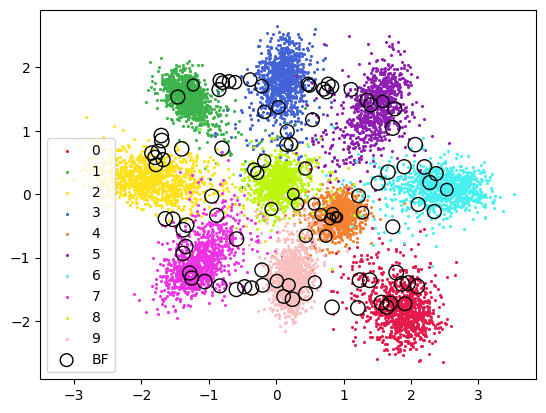

In [66]:
# call plot function and plot the result
plot(features, network)

### (Optional) Task 7a: Deep Feature Visualization & Task 8: Basis Function Visualization for another network

Follow the exact same setup as Task 7. This time, plot results for `network_minimal`.

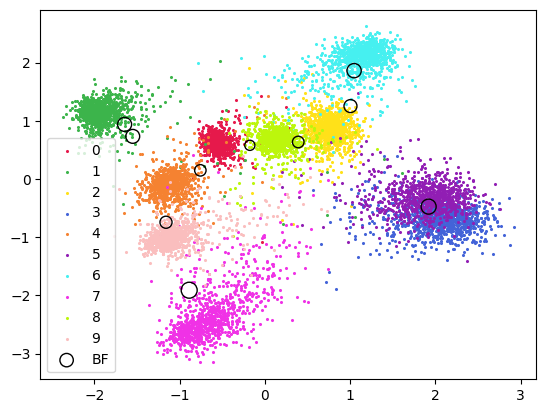

In [14]:
# instantiate plot function and plot the result
plot(features_minimal, network_minimal)